In [1]:
# Cell 1: imports & basic settings

import importlib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from IPython.display import display

import OTfunc as otf       
importlib.reload(otf)       

%matplotlib inline
plt.rcParams["figure.figsize"] = (6, 4)
plt.rcParams["axes.grid"] = True
plt.rcParams["font.size"] = 11


True tau (00217-style DGP): 0.1000000000103885


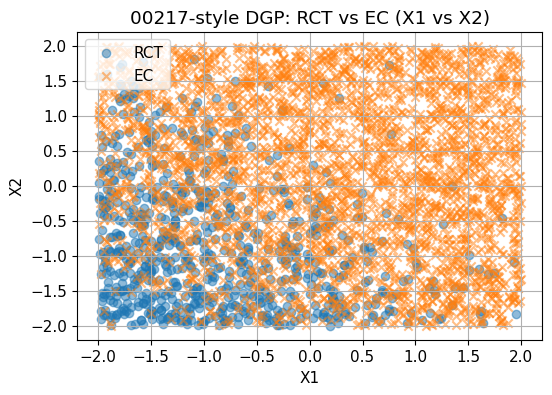

[Unweighted overlap diagnostics]
  max_abs_MD = 1.095
  mean_abs_MD = 1.063
  l2_MD = 1.842
  maha_d2 = 2.530

[OT-weighted EC balance diagnostics]
  max SMD   = 0.312
  ESS       = 414.3
  max_abs_MD= 0.279
  mean_abs_MD= 0.268
  l2_MD     = 0.465

[Covariate means: RCT vs EC (unweighted / OT-weighted)]


,covariate,RCT_mean,EC_unw,EC_OTw
0,X1,-0.874600,0.220085,-0.615951
1,X2,-0.835550,0.182831,-0.567601
2,X3,-0.846864,0.228811,-0.568268


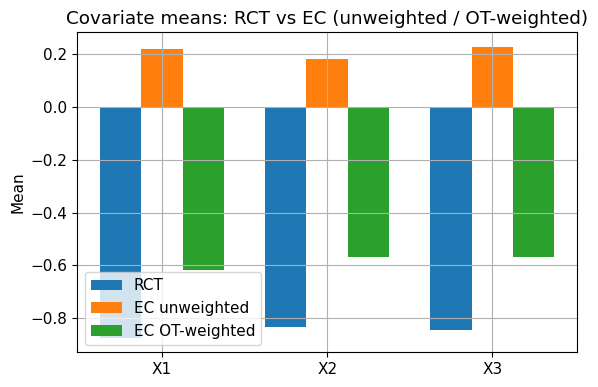

In [4]:
# Cell 2: one 00217-style dataset + covariate / balance checks

dat = otf.simulate_once_paper(
    n1=500, n0=250, nE=3000,
    truth="sample",   # 与论文 Section 6 一致
    seed=1
)
rct, ec, tau_true = dat["rct"], dat["ec"], dat["tau_true"]

print("True tau (00217-style DGP):", tau_true)

# --- Scatter of (X1, X2) for RCT vs EC ---

fig, ax = plt.subplots()
ax.scatter(rct["X1"], rct["X2"], alpha=0.5, label="RCT")
ax.scatter(ec["X1"],  ec["X2"],  alpha=0.5, marker="x", label="EC")
ax.set_xlabel("X1")
ax.set_ylabel("X2")
ax.set_title("00217-style DGP: RCT vs EC (X1 vs X2)")
ax.legend()
plt.show()

# --- Unweighted overlap diagnostics (OTfunc.overlap_metrics) ---

ov = otf.overlap_metrics(rct, ec, vars=("X1","X2","X3"))
print("[Unweighted overlap diagnostics]")
for k, v in ov.items():
    print(f"  {k} = {v:.3f}")

# --- OT weights (semi-relaxed) + OTfunc.ot_balance_diagnostics ---

Xr = rct[["X1","X2","X3"]].to_numpy(float)
Xe = ec[ ["X1","X2","X3"]].to_numpy(float)

w_ot = otf.ot_weights_semi_relaxed(Xe, Xr, eps=0.05, clip_ratio=15)
diag_ot = otf.ot_balance_diagnostics(rct, ec, w_ot, covariate_cols=("X1","X2","X3"))

print("\n[OT-weighted EC balance diagnostics]")
print(f"  max SMD   = {diag_ot['max_SMD']:.3f}")
print(f"  ESS       = {diag_ot['ESS']:.1f}")
print(f"  max_abs_MD= {diag_ot['max_abs_MD']:.3f}")
print(f"  mean_abs_MD= {diag_ot['mean_abs_MD']:.3f}")
print(f"  l2_MD     = {diag_ot['l2_MD']:.3f}")

# --- Compare covariate means (unweighted vs OT-weighted EC) ---

mu_r = Xr.mean(axis=0)
mu_e_unw = Xe.mean(axis=0)
mu_e_w   = w_ot @ Xe

cov_names = ["X1", "X2", "X3"]
mean_df = pd.DataFrame({
    "covariate": cov_names,
    "RCT_mean":  mu_r,
    "EC_unw":    mu_e_unw,
    "EC_OTw":    mu_e_w
})
print("\n[Covariate means: RCT vs EC (unweighted / OT-weighted)]")
display(mean_df)

fig, ax = plt.subplots()
x = np.arange(len(cov_names))
width = 0.25
ax.bar(x - width, mean_df["RCT_mean"].values, width=width, label="RCT")
ax.bar(x,         mean_df["EC_unw"].values,  width=width, label="EC unweighted")
ax.bar(x + width, mean_df["EC_OTw"].values,  width=width, label="EC OT-weighted")
ax.set_xticks(x)
ax.set_xticklabels(cov_names)
ax.set_ylabel("Mean")
ax.set_title("Covariate means: RCT vs EC (unweighted / OT-weighted)")
ax.legend()
plt.tight_layout()
plt.show()


lambda grid: [0.    0.025 0.05  0.075 0.1   0.125 0.15  0.175 0.2   0.225 0.25  0.275
 0.3   0.325 0.35  0.375 0.4   0.425 0.45  0.475 0.5  ]
MSE(lambda): [0.001507   0.00147077 0.00144103 0.00141778 0.00140102 0.00139077
 0.001387   0.00138973 0.00139895 0.00141466 0.00143687 0.00146557
 0.00150077 0.00154246 0.00159064 0.00164532 0.00170649 0.00177415
 0.00184831 0.00192896 0.00201611]


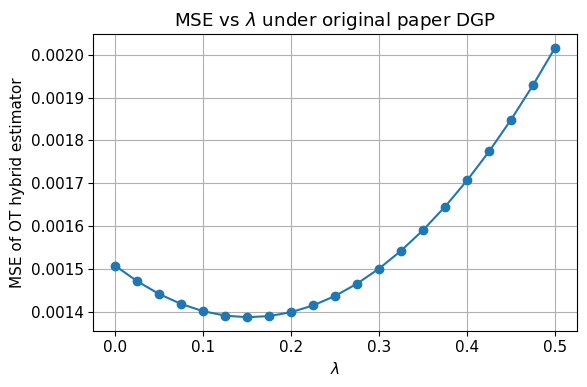

In [7]:
import numpy as np
import matplotlib.pyplot as plt

from OTfunc import simulate_once_paper, ot_weights_semi_relaxed


def run_mse_vs_lambda(
    lambdas=None,
    n_sim=300,
    n1=500,
    n0=250,
    nE=2000,
    eps=0.01,
    clip_ratio=15,
    base_seed=2025,
    truth="fullRCT",
):
    """
    Under the original paper's DGP setting (simulate_once_paper),
    compute the MSE of the OT hybrid estimator for different values of lambda.

    Parameters
    ----------
    lambdas : array-like
        Lambda grid (0–1). If None, use np.linspace(0, 1, 21).
    n_sim : int
        Number of Monte Carlo repetitions.
    n1, n0, nE : int
        Sample sizes of RCT treated / RCT control / EC, passed to simulate_once_paper.
    eps, clip_ratio : float
        OT hyperparameters passed to ot_weights_semi_relaxed.
    base_seed : int
        Base random seed for each repetition.
    truth : {"fullRCT", "sample"}
        Passed to simulate_once_paper; "fullRCT" is closer to the
        “reference RCT distribution” setup used in the paper.

    Returns
    -------
    lambdas : ndarray
    mse     : ndarray
        The MSE corresponding to each lambda.
    """
    if lambdas is None:
        lambdas = np.linspace(0.0, 1.0, 21)
    lambdas = np.asarray(lambdas, float)
    mse_accum = np.zeros_like(lambdas, dtype=float)

    for sim in range(n_sim):
        # Use a different seed at each repetition
        sim_seed = base_seed + sim

        sim_data = simulate_once_paper(
            n1=n1,
            n0=n0,
            nE=nE,
            seed=sim_seed,
            truth=truth,
        )
        rct = sim_data["rct"]
        ec = sim_data["ec"]
        tau_true = sim_data["tau_true"]

        # Extract covariates and outcomes
        X_rct = rct[["X1", "X2", "X3"]].to_numpy(float)
        X_ec = ec[["X1", "X2", "X3"]].to_numpy(float)
        A = rct["A"].to_numpy(int)
        Y_rct = rct["Y_alt"].to_numpy(float)
        Y_ec = ec["Y"].to_numpy(float)

        # RCT treated / control means
        muT = float(Y_rct[A == 1].mean())
        muC = float(Y_rct[A == 0].mean())

        # OT weights: following the “original theory”, use the RCT control group as the target
        X_tgt = X_rct[A == 0]
        w_ec = ot_weights_semi_relaxed(X_ec, X_tgt, eps=eps, clip_ratio=clip_ratio)
        muE = float(np.sum(w_ec * Y_ec))

        # For the current repetition, compute tau_hat(λ) on the entire lambda grid at once
        # tau_hat(λ) = muT - [(1-λ)*muC + λ*muE]
        tau_hat_lambda = muT - ((1.0 - lambdas) * muC + lambdas * muE)

        # Accumulate squared error
        errs = tau_hat_lambda - tau_true
        mse_accum += errs ** 2

    mse = mse_accum / float(n_sim)
    return lambdas, mse


if __name__ == "__main__":
    lambdas, mse = run_mse_vs_lambda(
        lambdas=np.linspace(0.0, 0.5, 21),
        n_sim=100,
        n1=500,
        n0=250,
        nE=3000,
        eps=0.01,
        clip_ratio=60,
        base_seed=123,
        truth="sample",
    )

    print("lambda grid:", lambdas)
    print("MSE(lambda):", mse)

    plt.figure()
    plt.plot(lambdas, mse, marker="o")
    plt.xlabel(r"$\lambda$")
    plt.ylabel("MSE of OT hybrid estimator")
    plt.title("MSE vs $\\lambda$ under original paper DGP")
    plt.grid(True)
    plt.tight_layout()
    plt.show()


In [6]:
# Cell 3: IPW (RCT only) vs OT(lambda*) under 00217 DGP

def mc_ipw_vs_ot_paper(R=200,
                        n1=500, n0=250, nE=3000,
                        eps_ot=0.01, clip_ot=60,
                        seed=123):
    rng = np.random.default_rng(seed)
    rows = []

    for _ in range(R):
        dat = otf.simulate_once_paper(
            n1=n1, n0=n0, nE=nE,
            truth="sample",
            seed=int(rng.integers(1, 10**9))
        )
        rct, ec, tau_true = dat["rct"], dat["ec"], dat["tau_true"]

        # RCT-only IPW
        tau_ipw = otf.ipw_rct_estimate(
            rct,
            x_cols=("X1","X2","X3"),
            outcome_col="Y_alt",
            treat_col="A"
        )
        rows.append({
            "method": "IPW (RCT only)",
            "err": tau_ipw - tau_true,
            "lambda_star": np.nan,
            "max_SMD": np.nan,
            "ESS": np.nan
        })

        # OT(lambda*)
        tau_ot, info_ot = otf.ot_lambda_star_rd(
            rct, ec,
            rct_outcome_col="Y_alt",
            ec_outcome_col="Y",
            treat_col="A",
            covariate_cols=("X1","X2","X3"),
            eps=eps_ot, clip_ratio=clip_ot
        )
        rows.append({
                "method": "OT (lambda*)",
                "err": tau_ot - tau_true,
                "lambda_star": info_ot["lambda_star"],
                "max_SMD": info_ot["max_SMD"],
                "ESS": info_ot["ESS"]
        })

    df = pd.DataFrame(rows)

    def _var(x):
        x = np.asarray(x, float)
        return np.var(x, ddof=1)
    def _mse(x):
        x = np.asarray(x, float)
        return np.mean(x**2)

    summary = df.groupby("method", as_index=False).agg(
        bias=("err","mean"),
        var =("err",_var),
        mse =("err",_mse),
        avg_lambda_star=("lambda_star","mean"),
        avg_max_SMD=("max_SMD","mean"),
        avg_ESS=("ESS","mean")
    )
    return summary, df

summary_paper, draws_paper = mc_ipw_vs_ot_paper(
    R=200,
    n1=500, n0=250, nE=3000,
    eps_ot=0.01, clip_ot=50,
    seed=1
)
print("Summary: 00217-style DGP, IPW vs OT(lambda*)")
display(summary_paper)


Summary: 00217-style DGP, IPW vs OT(lambda*)


,method,bias,var,mse,avg_lambda_star,avg_max_SMD,avg_ESS
0,IPW (RCT only),-0.001652,0.000980,0.000978,NaN,NaN,NaN
1,OT (lambda*),-0.012929,0.001337,0.001498,0.2342,0.174727,153.900397


Scenario = moderate_mixture
[Unweighted overlap diagnostics]
  max_abs_MD = 0.661
  mean_abs_MD = 0.291
  l2_MD = 0.679
  maha_d2 = 1.161


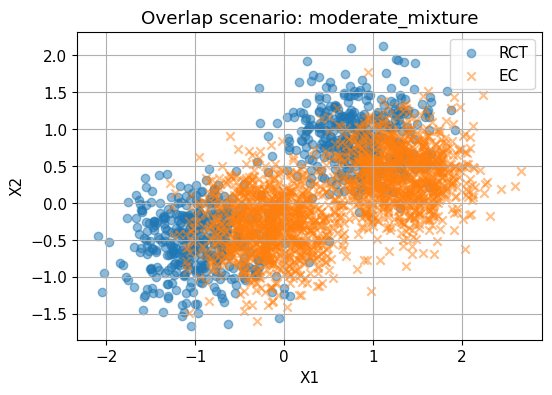


Scenario = bad_checkerboard
[Unweighted overlap diagnostics]
  max_abs_MD = 0.072
  mean_abs_MD = 0.041
  l2_MD = 0.081
  maha_d2 = 0.006


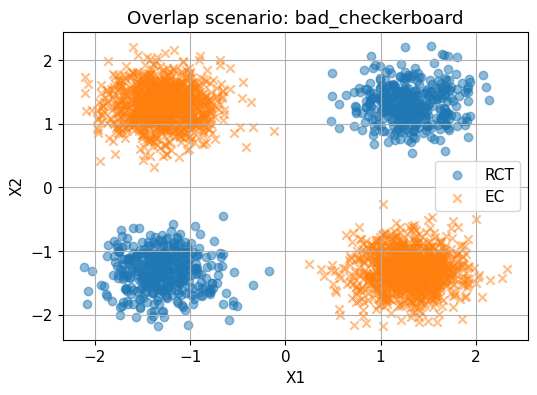


Scenario = wavy_tilted
[Unweighted overlap diagnostics]
  max_abs_MD = 0.616
  mean_abs_MD = 0.241
  l2_MD = 0.622
  maha_d2 = 0.584


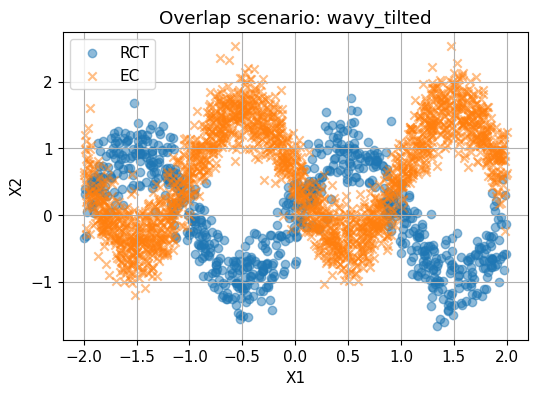

In [2]:
# Cell 4: visualize overlap scenarios

def show_overlap_example(scenario, seed=1):
    dat = otf.simulate_once_overlap(
        n1=500, n0=250, nE=2000,
        scenario=scenario,
        seed=seed
    )
    rct, ec = dat["rct"], dat["ec"]

    print(f"Scenario = {scenario}")
    ov = otf.overlap_metrics(rct, ec, vars=("X1","X2","X3"))
    print("[Unweighted overlap diagnostics]")
    for k, v in ov.items():
        print(f"  {k} = {v:.3f}")

    fig, ax = plt.subplots()
    ax.scatter(rct["X1"], rct["X2"], alpha=0.5, label="RCT")
    ax.scatter(ec["X1"],  ec["X2"],  alpha=0.5, marker="x", label="EC")
    ax.set_xlabel("X1")
    ax.set_ylabel("X2")
    ax.set_title(f"Overlap scenario: {scenario}")
    ax.legend()
    plt.show()

for scen in ["moderate_mixture", "bad_checkerboard", "wavy_tilted"]:
    show_overlap_example(scen, seed=1)
    print()


In [7]:
# Cell 5: IPW vs OT(lambda*) in overlap scenarios

def mc_ipw_vs_ot_overlap(
    scenario,
    R=200,
    n1=500, n0=250, nE=3000,
    eps_ot=0.05, clip_ot=15,
    seed=123
):
    rng = np.random.default_rng(seed)
    rows = []

    for _ in range(R):
        dat = otf.simulate_once_overlap(
            n1=n1, n0=n0, nE=nE,
            scenario=scenario,
            seed=int(rng.integers(1, 10**9))
        )
        rct, ec, tau_true = dat["rct"], dat["ec"], dat["tau_true"]

        # RCT-only IPW
        tau_ipw = otf.ipw_rct_estimate(
            rct,
            x_cols=("X1","X2","X3"),
            outcome_col="Y_alt",
            treat_col="A"
        )
        rows.append({
            "scenario": scenario,
            "method": "IPW (RCT only)",
            "err": tau_ipw - tau_true,
            "lambda_star": np.nan,
            "max_SMD": np.nan,
            "ESS": np.nan
        })

        # OT(lambda*)
        tau_ot, info_ot = otf.ot_lambda_star_rd(
            rct, ec,
            rct_outcome_col="Y_alt",
            ec_outcome_col="Y",
            treat_col="A",
            covariate_cols=("X1","X2","X3"),
            eps=eps_ot, clip_ratio=clip_ot
        )
        rows.append({
            "scenario": scenario,
            "method": "OT (lambda*)",
            "err": tau_ot - tau_true,
            "lambda_star": info_ot["lambda_star"],
            "max_SMD": info_ot["max_SMD"],
            "ESS": info_ot["ESS"]
        })

    df = pd.DataFrame(rows)

    def _var(x):
        x = np.asarray(x, float)
        return np.var(x, ddof=1)
    def _mse(x):
        x = np.asarray(x, float)
        return np.mean(x**2)

    summary = df.groupby(["scenario","method"], as_index=False).agg(
        bias=("err","mean"),
        var =("err",_var),
        mse =("err",_mse),
        avg_lambda_star=("lambda_star","mean"),
        avg_max_SMD=("max_SMD","mean"),
        avg_ESS=("ESS","mean")
    )
    return summary, df

summaries = []
for scen in ["moderate_mixture", "bad_checkerboard", "wavy_tilted"]:
    print(f"Running MC for scenario: {scen}")
    s, _ = mc_ipw_vs_ot_overlap(
        scen,
        R=200,
        n1=500, n0=250, nE=3000,
        eps_ot=0.1, clip_ot=10,
        seed=123
    )
    summaries.append(s)

summary_overlap = pd.concat(summaries, ignore_index=True)
display(summary_overlap)


Running MC for scenario: moderate_mixture
Running MC for scenario: bad_checkerboard
Running MC for scenario: wavy_tilted


,scenario,method,bias,var,mse,avg_lambda_star,avg_max_SMD,avg_ESS
0,moderate_mixture,IPW (RCT only),0.000485,0.000635,0.000632,NaN,NaN,NaN
1,moderate_mixture,OT (lambda*),0.002603,0.000696,0.000699,0.6880,0.184436,974.067880
2,bad_checkerboard,IPW (RCT only),0.001310,0.000511,0.000510,NaN,NaN,NaN
3,bad_checkerboard,OT (lambda*),0.014649,0.001461,0.001668,0.1009,0.052572,1818.431559
4,wavy_tilted,IPW (RCT only),0.001192,0.000684,0.000682,NaN,NaN,NaN
5,wavy_tilted,OT (lambda*),0.000141,0.000607,0.000604,0.7141,0.181657,1305.175703


In [3]:
# Cell 6: SM wrong / OM correct — OT(lambda*) vs Borrow-IPW

def mc_ot_vs_borrowipw_smWrong(
    R=200,
    n1=500, n0=250, nE=2000,
    eps_ot=0.05, clip_ot=15,
    seed=2025
):
    rng = np.random.default_rng(seed)
    rows = []

    for _ in range(R):
        dat = otf.simulate_once_smWrong_omCorrect(
            n1=n1, n0=n0, nE=nE,
            seed=int(rng.integers(1, 10**9))
        )
        rct, ec, tau_true = dat["rct"], dat["ec"], dat["tau_true"]

        # Borrow IPW-style RD
        tau_bipw = otf.borrow_ipw_rd(
            rct, ec,
            x_cols=("X1","X2","X3"),
            y_rct_col="Y_alt",
            y_ec_col="Y",
            treat_col="A"
        )
        rows.append({
            "method": "Borrow IPW",
            "err": tau_bipw - tau_true,
            "lambda_star": np.nan,
            "max_SMD": np.nan,
            "ESS": np.nan
        })

        # OT(lambda*)
        tau_ot, info_ot = otf.ot_lambda_star_rd(
            rct, ec,
            rct_outcome_col="Y_alt",
            ec_outcome_col="Y",
            treat_col="A",
            covariate_cols=("X1","X2","X3"),
            eps=eps_ot, clip_ratio=clip_ot
        )
        rows.append({
            "method": "OT (lambda*)",
            "err": tau_ot - tau_true,
            "lambda_star": info_ot["lambda_star"],
            "max_SMD": info_ot["max_SMD"],
            "ESS": info_ot["ESS"]
        })

    df = pd.DataFrame(rows)

    def _var(x):
        x = np.asarray(x, float)
        return np.var(x, ddof=1)
    def _mse(x):
        x = np.asarray(x, float)
        return np.mean(x**2)

    summary = df.groupby("method", as_index=False).agg(
        bias=("err","mean"),
        var =("err",_var),
        mse =("err",_mse),
        avg_lambda_star=("lambda_star","mean"),
        avg_max_SMD=("max_SMD","mean"),
        avg_ESS=("ESS","mean")
    )
    return summary, df

summary_smWrong, draws_smWrong = mc_ot_vs_borrowipw_smWrong(
    R=200,
    n1=500, n0=250, nE=3000,
    eps_ot=0.01, clip_ot=20,
    seed=2025
)
print("SM wrong / OM correct: Borrow IPW vs OT(lambda*)")
display(summary_smWrong)


SM wrong / OM correct: Borrow IPW vs OT(lambda*)


,method,bias,var,mse,avg_lambda_star,avg_max_SMD,avg_ESS
0,Borrow IPW,0.009554,0.000591,0.000679,NaN,NaN,NaN
1,OT (lambda*),0.011730,0.001492,0.001622,0.1535,0.209605,242.762676


In [2]:
# Cell 7: SM wrong / OM correct — OT(grid-OM) vs Borrow-IPW
def mc_ot_vs_borrowipw_smWrong_grid(
    R=200,
    n1=500,
    n0=250,
    nE=3000,
    eps_ot=0.05,
    clip_ot=20.0,
    lambda_grid=None,
    seed=2025,
):
    rng = np.random.default_rng(seed)
    if lambda_grid is None:
        lambda_grid = np.linspace(0.0, 0.5, 26)  # 0.00, 0.02, ..., 0.50

    rows = []

    for _ in range(R):
        dat = otf.simulate_once_smWrong_omCorrect(
            n1=n1,
            n0=n0,
            nE=nE,
            seed=int(rng.integers(1, 10**9)),
        )
        rct, ec, tau_true = dat["rct"], dat["ec"], dat["tau_true"]

        # Borrow IPW-style RD
        tau_bipw = otf.borrow_ipw_rd(
            rct,
            ec,
            x_cols=("X1", "X2", "X3"),
            y_rct_col="Y_alt",
            y_ec_col="Y",
            treat_col="A",
        )
        rows.append(
            {
                "method": "Borrow IPW",
                "err": tau_bipw - tau_true,
                "lambda_star": np.nan,
                "max_SMD": np.nan,
                "ESS": np.nan,
            }
        )

        # OT with lambda chosen by OM-calibrated grid search
        tau_ot, info_ot = otf.ot_lambda_grid_rd(
            rct,
            ec,
            rct_outcome_col="Y_alt",
            ec_outcome_col="Y",
            treat_col="A",
            covariate_cols=("X1", "X2", "X3"),
            eps=eps_ot,
            clip_ratio=clip_ot,
            lambda_grid=lambda_grid,
            om_degree2=True,
            om_l2=1e-4,
        )
        rows.append(
            {
                "method": "OT (grid-OM)",
                "err": tau_ot - tau_true,
                "lambda_star": info_ot["lambda_star"],
                "max_SMD": info_ot["max_SMD"],
                "ESS": info_ot["ESS"],
            }
        )

    df = pd.DataFrame(rows)

    def _var(x):
        x = np.asarray(x, float)
        return np.var(x, ddof=1)

    def _mse(x):
        x = np.asarray(x, float)
        return np.mean(x ** 2)

    summary = df.groupby("method", as_index=False).agg(
        bias=("err", "mean"),
        var=("err", _var),
        mse=("err", _mse),
        avg_lambda_star=("lambda_star", "mean"),
        avg_max_SMD=("max_SMD", "mean"),
        avg_ESS=("ESS", "mean"),
    )
    return summary, df


if __name__ == "__main__":
    summary_smWrong, draws_smWrong = mc_ot_vs_borrowipw_smWrong_grid(
        R=200,
        n1=500,
        n0=250,
        nE=3000,
        eps_ot=0.05,
        clip_ot=20.0,
        lambda_grid=np.linspace(0.0, 0.5, 26),
        seed=2025,
    )
    print("SM wrong / OM correct: Borrow IPW vs OT(grid-OM)")
    print(summary_smWrong)


SM wrong / OM correct: Borrow IPW vs OT(grid-OM)
         method      bias       var       mse  avg_lambda_star  avg_max_SMD  \
0    Borrow IPW  0.009554  0.000591  0.000679              NaN          NaN   
1  OT (grid-OM) -0.000550  0.001432  0.001425              0.0     0.223685   

      avg_ESS  
0         NaN  
1  573.524147  
